<a href="https://colab.research.google.com/github/Phanttan/Deep-learning-with-Python-Francois-Chollet/blob/main/3_5_classifying_newswires_Integertensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
keras.__version__

'2.4.3'

## The Reuters dataset


We will be working with the _Reuters dataset_, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, 
widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each 
topic has at least 10 examples in the training set.

Like IMDB and MNIST, the Reuters dataset comes packaged as part of Keras. Let's take a look right away:

In [3]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 0s 0us/step


## Preparing the data

We can vectorize the data with the exact same code as in our previous example:

In [4]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

557056/550378 [==============================] - 0s 0us/step


In [5]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [6]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

In [7]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [8]:
train_labels.max()

45

## Building our network


This topic classification problem looks very similar to our previous movie review classification problem: in both cases, we are trying to 
classify short snippets of text. There is however a new constraint here: the number of output classes has gone from 2 to 46, i.e. the 
dimensionality of the output space is much larger. 

In a stack of `Dense` layers like what we were using, each layer can only access information present in the output of the previous layer. 
If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each 
layer can potentially become an "information bottleneck". In our previous example, we were using 16-dimensional intermediate layers, but a 
16-dimensional space may be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks, 
permanently dropping relevant information.

For this reason we will use larger layers. Let's go with 64 units:

In [9]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

In [10]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Validating our approach

Let's set apart 1,000 samples in our training data to use as a validation set:

In [11]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Now let's train our network for 20 epochs:

In [12]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 54ms/step - loss: 2.5885 - accuracy: 0.4838 - val_loss: 1.5949 - val_accuracy: 0.6440
Epoch 2/20
16/16 [==============================] - 1s 41ms/step - loss: 1.3376 - accuracy: 0.7100 - val_loss: 1.2772 - val_accuracy: 0.7260
Epoch 3/20
16/16 [==============================] - 1s 41ms/step - loss: 1.0051 - accuracy: 0.7824 - val_loss: 1.1143 - val_accuracy: 0.7550
Epoch 4/20
16/16 [==============================] - 1s 41ms/step - loss: 0.8016 - accuracy: 0.8279 - val_loss: 1.0584 - val_accuracy: 0.7760
Epoch 5/20
16/16 [==============================] - 1s 43ms/step - loss: 0.6316 - accuracy: 0.8649 - val_loss: 1.0393 - val_accuracy: 0.7720
Epoch 6/20
16/16 [==============================] - 1s 42ms/step - loss: 0.5084 - accuracy: 0.8904 - val_loss: 0.9607 - val_accuracy: 0.8070
Epoch 7/20
16/16 [==============================] - 1s 41ms/step - loss: 0.4115 - accuracy: 0.9119 - val_loss: 0.9621 - val_accuracy: 0.7980
Epoch 8/20
16

Let's display its loss and accuracy curves:

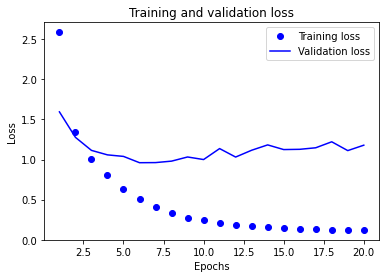

In [13]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

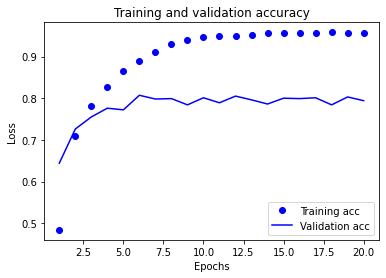

In [15]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

It seems that the network starts overfitting after 5 epochs. Let's train a new network from scratch for 5 epochs, then let's evaluate it on 
the test set:

In [16]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=5,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/5
16/16 [==============================] - 1s 50ms/step - loss: 2.6461 - accuracy: 0.4402 - val_loss: 1.7444 - val_accuracy: 0.6050
Epoch 2/5
16/16 [==============================] - 1s 41ms/step - loss: 1.4553 - accuracy: 0.6883 - val_loss: 1.3232 - val_accuracy: 0.7050
Epoch 3/5
16/16 [==============================] - 1s 41ms/step - loss: 1.0976 - accuracy: 0.7532 - val_loss: 1.1663 - val_accuracy: 0.7440
Epoch 4/5
16/16 [==============================] - 1s 41ms/step - loss: 0.8579 - accuracy: 0.8082 - val_loss: 1.0983 - val_accuracy: 0.7500
Epoch 5/5
71/71 [==============================] - 0s 2ms/step - loss: 1.0729 - accuracy: 0.7649


In [ ]:
results

[0.9852544665336609, 0.784060537815094]

## Generating predictions on new data

We can verify that the `predict` method of our model instance returns a probability distribution over all 46 topics. Let's generate topic 
predictions for all of the test data:

In [35]:
predictions = model.predict(x_test)

Each entry in `predictions` is a vector of length 46:

In [36]:
predictions[0]

array([1.44869802e-04, 3.87224456e-04, 1.92206226e-05, 9.61363077e-01,
       2.04092134e-02, 4.24569407e-06, 7.70175175e-05, 3.41799159e-06,
       1.60565751e-03, 2.59566033e-04, 1.65770671e-05, 1.02506019e-03,
       4.58203649e-05, 1.13826687e-03, 3.72761097e-05, 4.20715987e-05,
       6.09523151e-03, 3.45853943e-04, 4.42954406e-05, 2.56729731e-03,
       6.44316373e-04, 2.10918646e-04, 2.89967938e-05, 1.19870943e-04,
       1.82262113e-04, 4.08647436e-04, 5.45033436e-05, 2.34174859e-05,
       7.38241943e-04, 1.33847934e-04, 1.45953891e-05, 3.93074879e-05,
       2.77130486e-04, 2.02313777e-06, 3.64819134e-05, 1.77428626e-06,
       6.48316985e-04, 1.27002995e-05, 1.40963330e-05, 4.04697203e-04,
       2.21001421e-04, 1.08797365e-04, 3.09638381e-05, 5.44378599e-06,
       4.69758334e-06, 1.75095477e-06], dtype=float32)

In [38]:
np.argmax(predictions[0])

3

## A different way to handle the labels and the loss

We mentioned earlier that another way to encode the labels would be to cast them as an integer tensor (the last way is one-hot-label), like such:

In [17]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [18]:
y_val = y_train[:1000]
partial_x_train = x_train[1000:]
partial_y_train = y_train[1000:]

In [20]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=5,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/5
63/63 [==============================] - 1s 19ms/step - loss: 1.8140 - accuracy: 0.6040 - val_loss: 1.3564 - val_accuracy: 0.6810
Epoch 2/5
63/63 [==============================] - 2s 26ms/step - loss: 1.0042 - accuracy: 0.7766 - val_loss: 1.0712 - val_accuracy: 0.7500
Epoch 3/5
63/63 [==============================] - 2s 28ms/step - loss: 0.6743 - accuracy: 0.8508 - val_loss: 0.9794 - val_accuracy: 0.7930
Epoch 4/5
63/63 [==============================] - 2s 29ms/step - loss: 0.4620 - accuracy: 0.9019 - val_loss: 1.0157 - val_accuracy: 0.7910
Epoch 5/5
63/63 [==============================] - 2s 30ms/step - loss: 0.3297 - accuracy: 0.9270 - val_loss: 0.9700 - val_accuracy: 0.8130


## Wrapping up


Here's what you should take away from this example:

* If you are trying to classify data points between N classes, your network should end with a `Dense` layer of size N.
* In a single-label, multi-class classification problem, your network should end with a `softmax` activation, so that it will output a 
probability distribution over the N output classes.
* _Categorical crossentropy_ is almost always the loss function you should use for such problems. It minimizes the distance between the 
probability distributions output by the network, and the true distribution of the targets.
* There are two ways to handle labels in multi-class classification:
    ** Encoding the labels via "categorical encoding" (also known as "one-hot encoding") and using `categorical_crossentropy` as your loss 
function.
    ** Encoding the labels as integers and using the `sparse_categorical_crossentropy` loss function.
* If you need to classify data into a large number of categories, then you should avoid creating information bottlenecks in your network by having 
intermediate layers that are too small.